# SimMod 1. Video features
## 1. Author Documentation

- Alexander Haberl (11806899)
- Alina Godun (01569197)

### Timesheets
#### Alexander Haberl

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 15:00-16:00 | Preparation for registration assesment test |
| 2023/10/10 | 18:45-19:10 | Registration assesment test |
| 2023/10/12 | 10:00-11:00 | Pre-lecture meeting |
| 2023/10/19 | 18:00-22:00 | Watching lectures 1 and 2 |
| 2023/10/26 | 17:00-22:00 | Watching lectures 3 - 5 |
| 2023/11/02 | 18:00-22:00 | Watching lectures 6 and 7 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/09 | 19:00-22:00 | Watching lectures 8 and 9 |
| 2023/11/19 | 16:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 00:00-02:30 | Writing abstracts for SimMod 1 and 2 |
| 2023/12/04 | 21:00-00:00 | Setting up the repository and environment |
| 2023/12/09 | 10:00-22:00 | First audio and video features for Kermit and Statler & Waldorf |
| 2023/12/09 | 10:30-20:00 | First experiments, feature refinement, training classifiers, creating clean intermediate hand in file |
| 2024/01/03 | 11:00-22:00 | Optical flow + features on top of optical flow |
| 2024/01/04 | 11:00-20:00 | Features on top of optical flow, audio features |
| 2024/01/12 | 17:00-xx:00 | SimMod Hand In Notebook |

#### Alina Godun

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 17:30-18:30 | Preparation for registration assesment test |
| 2023/10/10 | 19:10-19:30 | Registration assesment test |
| 2023/10/26 | 09:00-12:00 | Watching lectures 1 and 2|
| 2023/10/27 | 19:00-21:00 | Watching lecture 3|
| 2023/10/28 | 20:00-00:00 | Watching lectures 4 to 6 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/18 | 16:00-20:00 | Watching lectures 7 and 8 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 19:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 19:00-02:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/12/09 | 10:00-22:00 | First audio and video features for Kermit and Statler & Waldorf |
| 2023/12/09 | 10:30-20:00 | First experiments, feature refinement, training classifiers, creating clean intermediate hand in file |
| 2024/01/03 | 11:00-22:00 | Train-test split, cross-validation, audio features, plots |
| 2024/01/04 | 11:00-20:00 | Features on top of optical flow, audio features, plots |
| 2024/01/12 | 17:00-xx:00 | SimMod Hand In Notebook |

## 2. Environment
To install all required libraries, create a conda environment from the conda_env.yml file:

```conda env create -f conda_env.yml```

Then activate the environment:

```conda activate SimilarityModeling```

Start jupyterlab (optional):

```jupyter lab```

## 3. Train Test Splitting

We can't randomly sample frames, because two neighboring frames are very, very similar and would lead to data leakage.
Therefore we split each episode into 2 parts of approximately equal length. Cuts were made when a new scene started, ensuring that no scene is present in both parts. This results in 6 episode partitions in total. 

We perfom nested cross-validation. 5/6 splits are used for the inner CV-loop (4/6 are used for training and 1/6 is used for validation). The outer CV-loop uses 1/6 as a testset.

The inner CV-loop is for hyperparameter tuning. All parameter combinations of the classifiers are evaluated on on each of the inner CV-folds. The hyperparameter-combination that performs the best on average is chosen for each classifier. Then each classifier is retrained on the whole 5/6 of the train-validation data with its best hyperparameters and then evaluated on the test-set. The final result is the average for each classifier over all test-folds. The best model is the one that performs the best on the outer-loop on average. 

Basically the inner-loop is for automatic hyperparameter tuning (and we don't care about the actual values of the hyperparameters), while the outer loop is for model comparison.

By doing nested cross-validation, we don't have to ensure that the test-set is representative because all frames are used for testing. If we only did holdout we would have a test-set with stronger bias, which might favor one classifier.

## 4. Feature extraction

### 4.1 Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import re
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from utils import io, train, eval
from utils import feature_engineering as fe

In [10]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

To compute the features set the flags to ```True```. The features are saved in the ```data/features``` directory after computation.

In [4]:
extract_optical_flow = False
extract_dominant_hues = False
extract_kermit_pixels = False

### 4.2 Optical Flow

Our first feature uses dense optical flow computed from cv.calcOpticalFlowFarneback() to estimate foreground masks. We convert the flow into a magnitude and angle. We compute a dynamic threshold based on the mean and std-dev of the magnitude in the current frame. We create a foreground mask based on the magnitudes of each pixel: If the magnitude of the pixel is bigger than the dynamic threshold it is part of the foreground. This works really well to separate foreground and background if the character are moving (even slight motions are good enough) and if the camera is static.

We save the masks as a video and will reuse them for some of the other features.
We also use the mean and std-deviation of the flow-magnitude as a feature, which might help the classifier to distinguish whether the characters or the camera moved.

In [ ]:
if extract_optical_flow:
    for ep in episode_names:
        fe.create_foreground_masks_video(video_paths[ep])

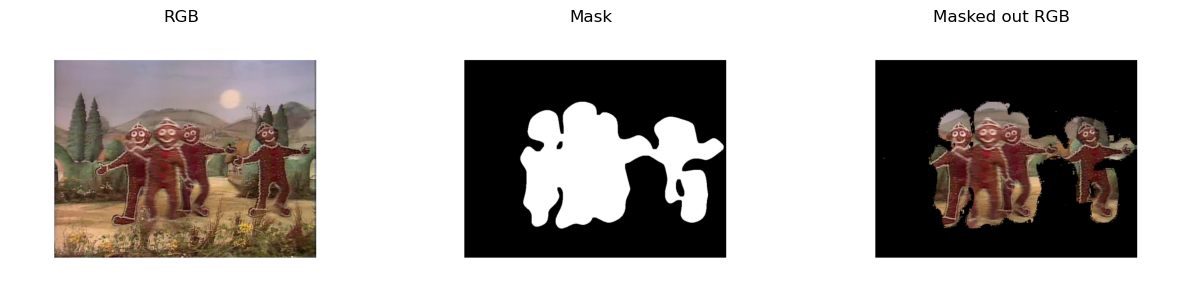

In [36]:
path_mask = "../data/images/opticalflow_mask.png"
path_rgb = "../data/images/opticalflow_rgb.png"
path_masked = "../data/images/opticalflow_masked.png"
mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)
rgb = cv2.imread(path_rgb)
masked = cv2.imread(path_masked)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.title("RGB")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(masked)
plt.title("Masked out RGB")
plt.axis("off")
plt.show()

In [ ]:
if extract_optical_flow:
    ep1 = pickle.load(open("../data/features/Muppets-02-01-01_foreground.pkl", "rb"))
    ep2 = pickle.load(open("../data/features/Muppets-02-04-04_foreground.pkl", "rb"))
    ep3 = pickle.load(open("../data/features/Muppets-03-04-03_foreground.pkl", "rb"))

    flow_features = {}
    flow_features['Muppets-02-01-01'] = ep1
    flow_features['Muppets-02-04-04'] = ep2
    flow_features['Muppets-03-04-03'] = ep3

    pickle.dump(flow_features, open("../data/features/flow_features.pkl", "wb"))

### 4.3 Kermit color pixels

This feature uses the foreground masks from 4.2. 

We count the number of kermit-coloured pixels in the foreground, background and the ratio between them (foreground/background).
We had issues with only counting the number of kermit-coloured pixels in the foreground, because the masks are imperfect (so parts of the background are often included), and some of the episode have many kermit-coloured pixels in the background.
Therefore we also compute how many kermit-coloured pixels are in the background and the ratio between them, so that the classifier has an easier time of detecting kermit.

We defined the kermit colour as (HSV values following the OpenCV convention):
- Hue between 25-50
- Value between 80-180

In [ ]:
if extract_kermit_pixels:
    feats = {}
    for ep in episode_names:
        feat = fe.get_kermitian_pixels(video_paths[ep], ep)
        feats[ep] = feat

    pickle.dump(feats, open("../data/features/kermit_pixels.pkl", "wb"))

### 4.4 Dominant Hues

We compute the 5 most dominant hues for each frame. The frame is converted into the HSV color space. The frame is then clustered into 5 clusters with k-means based on the HUES alone. We also compute the percentage of each cluster (how many percent of the pixels are asigned to this cluster).

We compute the dominant hues for the:
- background (based on the inverted foreground mask) 
- foreground (based on the foreground mask)
- whole frame

In [ ]:
def extract_dominant_hues(video_paths, type, n_clusters = 5, batch_size = 2048):
    hue_feat_list = {}
    
    for ep in episode_names:
        hue_feat_list[ep] = {}
        hue_arr = fe.get_dominant_colors(video_paths[ep], ep, n_clusters, batch_size, type=type)
        hue_feat_list[ep]['hue_list'] = hue_arr  

    pickle.dump(hue_feat_list, open(f"../data/features/hue_feat_list_{type}.pkl", "wb"))

In [ ]:
if extract_dominant_hues:
    extract_dominant_hues(video_paths=video_paths, type='full')
    extract_dominant_hues(video_paths=video_paths, type='foreground')
    extract_dominant_hues(video_paths=video_paths, type='background')

## 5. Classification

### 5.1 Load features

The (pre-)computed features are loaded from the ```data/features``` directory.

In [34]:
final_df = gt_df.copy()

In [35]:
flow_feat_dict = pickle.load(open("../data/features/flow_features.pkl", "rb"))

for ep in episode_names:
    current_ep_feats = flow_feat_dict[ep]
    for feat_name, feats in current_ep_feats.items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feats[1:]

In [36]:
kermit_pixels = pickle.load(open("../data/features/kermit_pixels.pkl", "rb"))

for ep in episode_names:
    for feat in kermit_pixels[ep].keys():
        final_df.loc[final_df['episode'] == ep, feat] = kermit_pixels[ep][feat]

In [37]:
for hue_feat_type in ['full', 'background', 'foreground']:
    hue_feat_list = pickle.load(open(f"../data/features/hue_feat_list_{hue_feat_type}.pkl", "rb"))

    for ep in episode_names:
        current_hue_feat_list = hue_feat_list[ep]['hue_list']
        for i, col_name in enumerate([f'percentage_{hue_feat_type}', f'hue_{hue_feat_type}']):
            for k in range(current_hue_feat_list.shape[1]):
                final_df.loc[final_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

### 5.2 Run experiments

#### 5.2.1 Kermit

In [27]:
save_results = True
target_col = 'Kermit'
split_col = 'episode_split'
split_ids = final_df[split_col].unique().sort()

train_cols = [c for c in final_df.columns 
              if 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- mean_flow
- std_dev_flow
- num_kermit_pixels_foreground
- num_kermit_pixels_background
- kermit_pixels_ratio
- percentage_full_0
- percentage_full_1
- percentage_full_2
- percentage_full_3
- percentage_full_4
- hue_full_0
- hue_full_1
- hue_full_2
- hue_full_3
- hue_full_4
- percentage_background_0
- percentage_background_1
- percentage_background_2
- percentage_background_3
- percentage_background_4
- hue_background_0
- hue_background_1
- hue_background_2
- hue_background_3
- hue_background_4
- percentage_foreground_0
- percentage_foreground_1
- percentage_foreground_2
- percentage_foreground_3
- percentage_foreground_4
- hue_foreground_0
- hue_foreground_1
- hue_foreground_2
- hue_foreground_3
- hue_foreground_4


In [ ]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [50, 100]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'clf__max_depth': [50, 100]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [1, 3, 10]
        },
    }
]

In [ ]:
eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results)

#### 5.2.2 Statler & Waldorf

In [38]:
save_results = True
target_col = 'StatlerWaldorf'
split_col = 'episode_split'
split_ids = final_df[split_col].unique().sort()

train_cols = [c for c in final_df.columns 
              if 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- mean_flow
- std_dev_flow
- num_kermit_pixels_foreground
- num_kermit_pixels_background
- kermit_pixels_ratio
- percentage_full_0
- percentage_full_1
- percentage_full_2
- percentage_full_3
- percentage_full_4
- hue_full_0
- hue_full_1
- hue_full_2
- hue_full_3
- hue_full_4
- percentage_background_0
- percentage_background_1
- percentage_background_2
- percentage_background_3
- percentage_background_4
- hue_background_0
- hue_background_1
- hue_background_2
- hue_background_3
- hue_background_4
- percentage_foreground_0
- percentage_foreground_1
- percentage_foreground_2
- percentage_foreground_3
- percentage_foreground_4
- hue_foreground_0
- hue_foreground_1
- hue_foreground_2
- hue_foreground_3
- hue_foreground_4


In [46]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [10],
            'clf__max_depth': [10]
            # 'clf__n_estimators': [10, 50],
            # 'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            # 'clf__max_depth': [20, 50]
            'clf__max_depth': [10]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            # 'clf__n_neighbors': [1, 3, 10]
            'clf__n_neighbors': [1]
        },
    }
]

prpr
Train splits: [0, 3, 2, 5, 4], Test split: 1
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 3, 2, 5, 4], Test split: 0
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 2, 5, 4], Test split: 3
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 3, 5, 4], Test split: 2
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 3, 2, 4], Test split: 5
Training RandomForest...
Training DecisionTree...
Training KNN...
Train splits: [1, 0, 3, 2, 5], Test split: 4
Training RandomForest...
Training DecisionTree...
Training KNN...


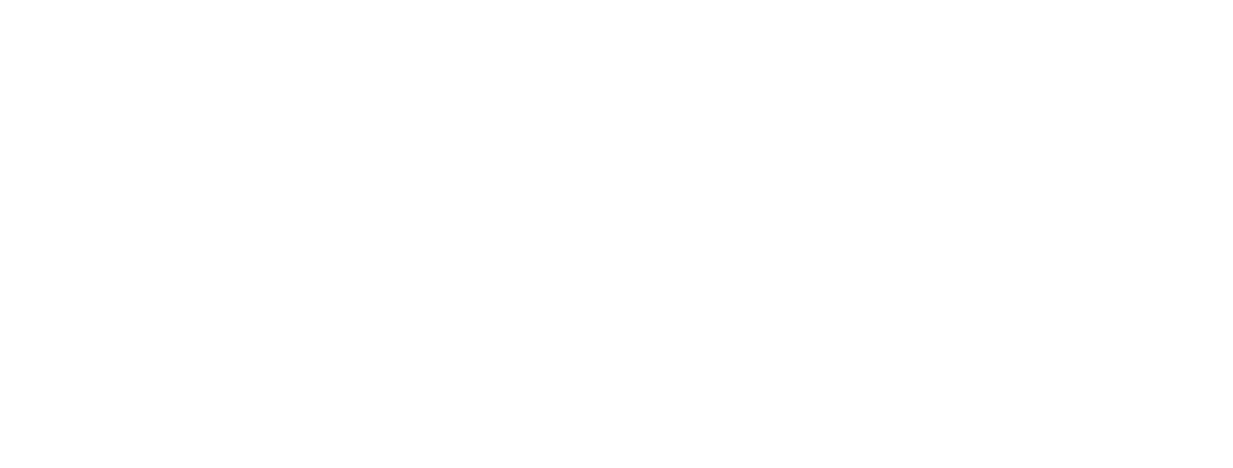

In [48]:
eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results)

## 6. Results & Discussion

#### 6.1 Kermit

In [103]:
target_col = 'Kermit'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_video_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_video_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_video_tpr_info.pkl", "rb"))

In [139]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

In [113]:
clf_dict_outer.keys()

dict_keys(['RandomForest', 'DecisionTree', 'KNN'])

RandomForest
DecisionTree
KNN


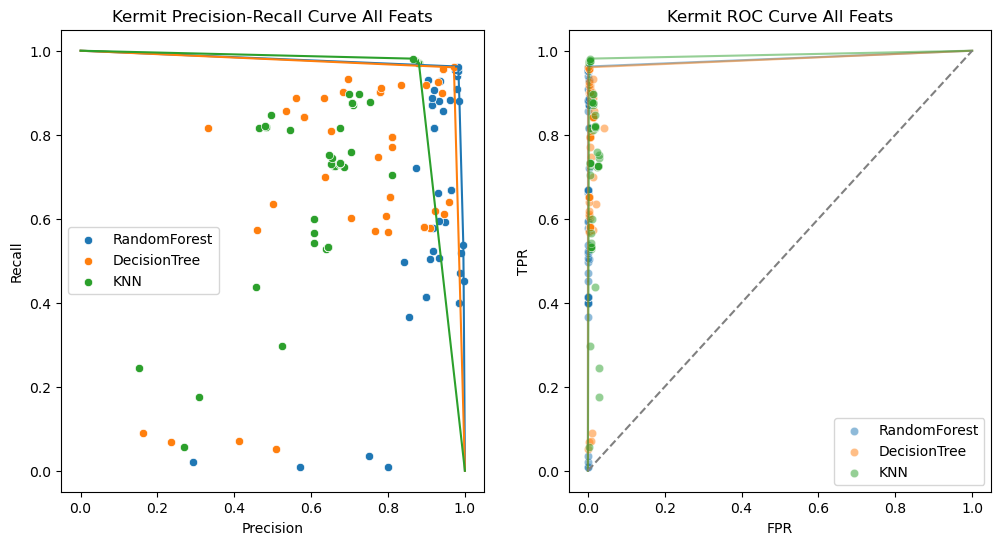

In [186]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0])
eval.plot_roc_curve(fpr_dict, tpr_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1])

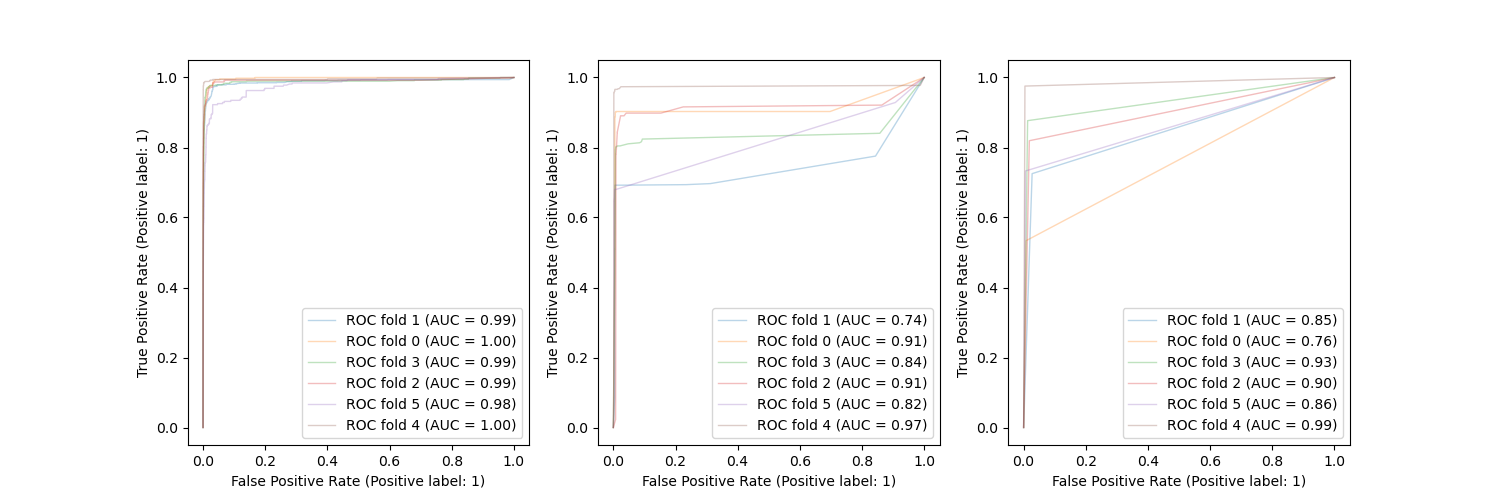

In [106]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

[Text(0.5, 1.0, 'Kermit Feature importance (from RandomForest)')]

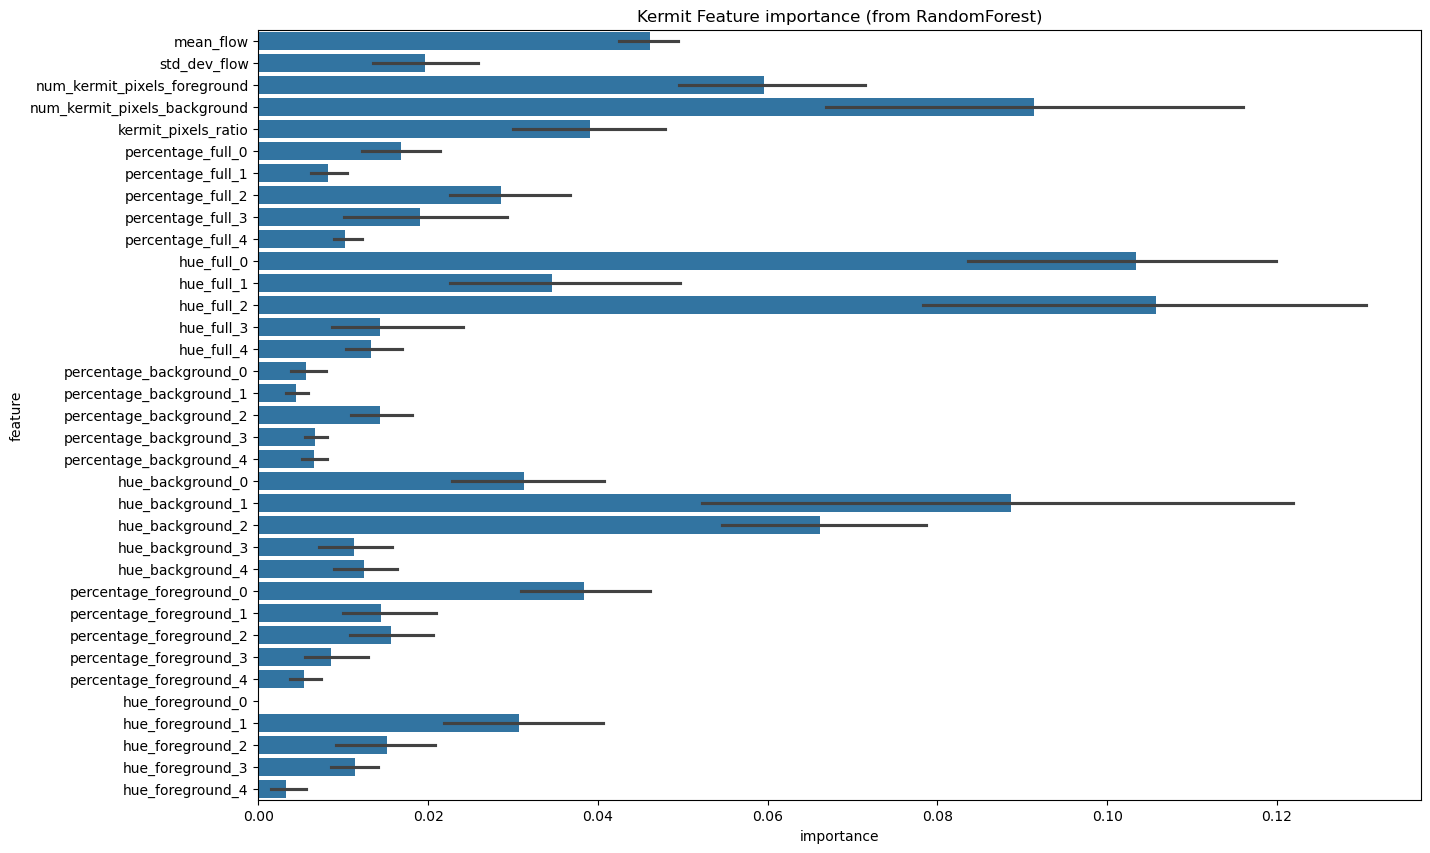

In [107]:
feature_importance_df = eval.get_feature_importance_rf(train_cols, clf_dict_outer)

_, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=feature_importance_df, y='feature', x='importance')
ax.set(title=f'{target_col} Feature importance (from RandomForest)')

#### 6.2 Statler & Waldorf

In [86]:
target_col = 'StatlerWaldorf'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_video_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_video_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_video_tpr_info.pkl", "rb"))

In [87]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

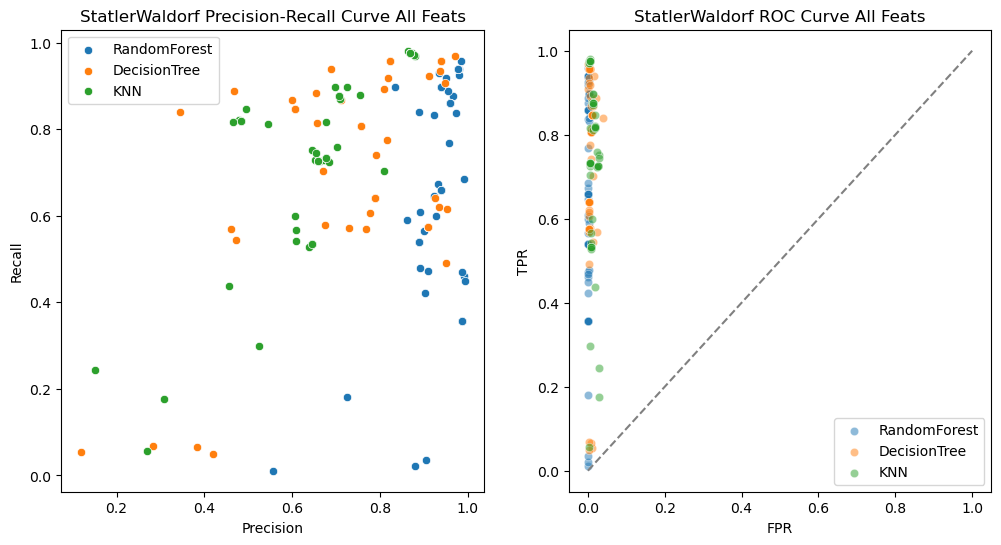

In [88]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0])
eval.plot_roc_curve(fpr_dict, tpr_dict, clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1])


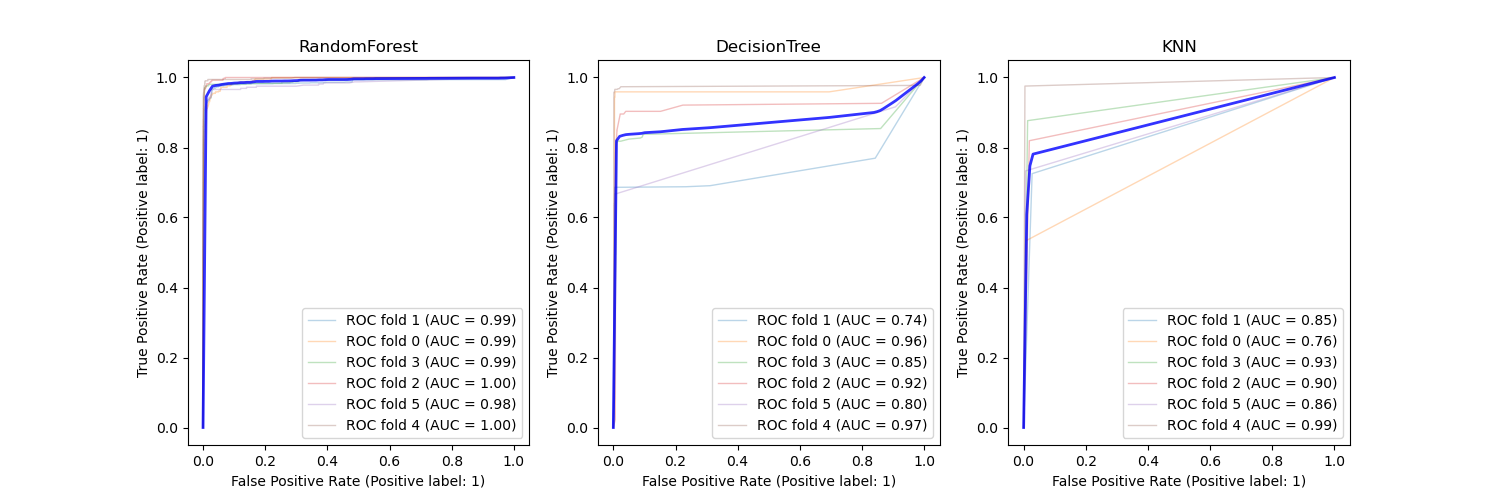

In [89]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

[Text(0.5, 1.0, 'StatlerWaldorf Feature importance (from RandomForest)')]

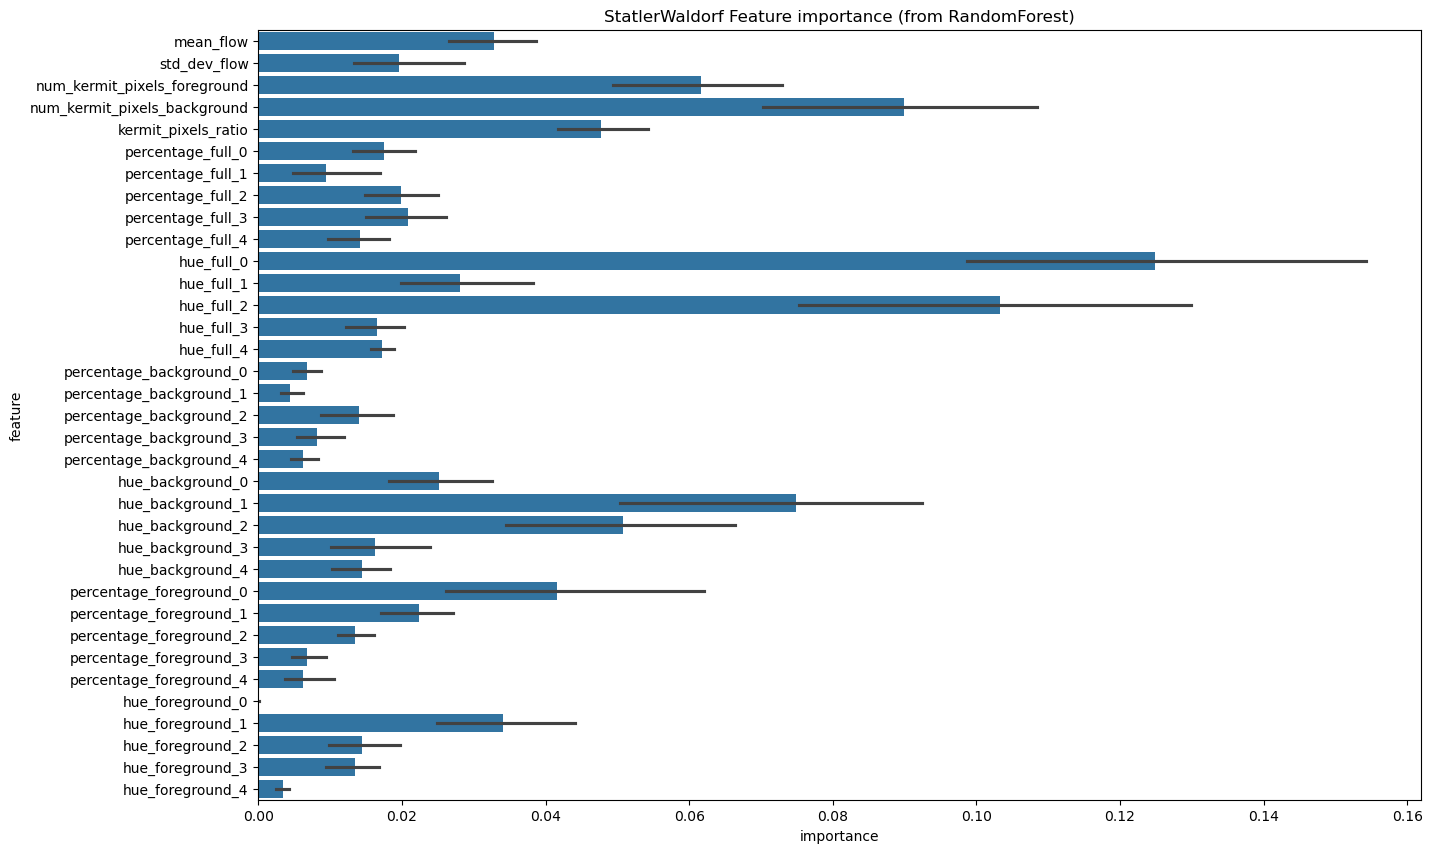

In [102]:
feature_importance_df = eval.get_feature_importance_rf(train_cols, clf_dict_outer)

_, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=feature_importance_df, y='feature', x='importance')
ax.set(title=f'{target_col} Feature importance (from RandomForest)')